In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [14]:
"""--가 들어가야 함"""
import argparse
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2 

from ctgan.data import read_csv, read_tsv, write_tsv
from ctgan.synthesizers.ctgan import CTGAN
def _parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument('--epochs', default=150, type=int, help='Number of training epochs')
    ap.add_argument('--tsv', default=False, action='store_true', help='Load data in TSV format instead of CSV')
    ap.add_argument('--no-header', dest='header', action='store_false', help='The CSV file has no header. Discrete columns will be indices.')

    ap.add_argument('--metadata', '--metadata', default=False, help='Path to the metadata')
    # 범주형 변수들이 콤마로 구분된 형태로 하나의 문자열로 들어감
    # ap.add_argument('--discrete', default='CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,STATUS', help='Comma separated list of discrete columns without whitespaces.')
    ap.add_argument('--discrete', default='workclass,education,marital-status,occupation,relationship,race,gender,native-country,income', help='Comma separated list of discrete columns without whitespaces.')
    # ap.add_argument('--discrete', default='credit.policy,purpose', help='Comma separated list of discrete columns without whitespaces.')
    ap.add_argument('--num-samples', type=int, help='Number of rows to sample. Defaults to the training data size')

    ap.add_argument('--generator_lr', type=float, default=2e-4, help='Learning rate for the generator.')
    ap.add_argument('--discriminator_lr', type=float, default=2e-4, help='Learning rate for the discriminator.')

    ap.add_argument('--generator_decay', type=float, default=1e-6, help='Weight decay for the generator.')
    ap.add_argument('--discriminator_decay', type=float, default=0, help='Weight decay for the discriminator.')

    ap.add_argument('--embedding_dim', type=int, default=128, help='Dimension of input z to the generator.')
    ap.add_argument('--generator_dim', type=str, default='256,256', help='Dimension of each generator layer. ')
    ap.add_argument('--discriminator_dim', type=str, default='256,256', help='Dimension of each discriminator layer. ')

    ap.add_argument('--batch_size', type=int, default=500, help='Batch size. Must be an even number.')
    ap.add_argument('--save', default=None, type=str, help='A filename to save the trained synthesizer.')
    ap.add_argument('--load', default=None, type=str, help='A filename to load a trained synthesizer.')

    ap.add_argument('--sample_condition_column', default=None, type=str, help='Select a discrete column name.') # 맨 마지막 sample을 생성할 때 사용되는 것
    ap.add_argument('--sample_condition_column_value', default=None, type=str, help='Specify the value of the selected discrete column.') # 맨 마지막 생성할 때 주의깊게 봐야 할 카테고리

    ap.add_argument('--data', default='CHECK_DATASETS/train_adult.csv', help='Path to training data')
    ap.add_argument('--output', default='FAKE_DATASETS/VCTGAN_adult.csv', help='Path of the output file') # 출력 파일 이름

    args = ap.parse_args(args=[])
    print('--------Parameters--------')
    print(args)
    print('--------------------------')
    return args

In [15]:
args = _parse_args()
data, discrete_columns = read_csv(args.data, args.metadata, args.header, args.discrete)

--------Parameters--------
Namespace(epochs=150, tsv=False, header=True, metadata=False, discrete='workclass,education,marital-status,occupation,relationship,race,gender,native-country,income', num_samples=None, generator_lr=0.0002, discriminator_lr=0.0002, generator_decay=1e-06, discriminator_decay=0, embedding_dim=128, generator_dim='256,256', discriminator_dim='256,256', batch_size=500, save=None, load=None, sample_condition_column=None, sample_condition_column_value=None, data='CHECK_DATASETS/train_adult.csv', output='FAKE_DATASETS/VCTGAN_adult.csv')
--------------------------


In [16]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
vanilla_ctgna_df = pd.read_csv('FAKE_DATASETS/VCTGAN_adult.csv')
vanilla_ctgna_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,37,Private,229982,Assoc-acdm,12,Never-married,Farming-fishing,Not-in-family,Black,Male,-19,-1,35,United-States,>50K
1,33,Private,63059,Assoc-voc,7,Divorced,Priv-house-serv,Not-in-family,Black,Female,16,-1,40,United-States,<=50K
2,21,Private,99368,HS-grad,9,Divorced,Other-service,Wife,White,Female,13,0,22,United-States,<=50K
3,36,Self-emp-inc,145608,Masters,14,Married-civ-spouse,Sales,Husband,Black,Male,29,-1,40,United-States,>50K
4,53,Private,144949,Bachelors,13,Separated,Exec-managerial,Not-in-family,White,Female,-5,1,40,United-States,<=50K


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
vanilla_ctgna_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
continuous_list = []
categorical_list = []
for col in data.columns:
    if data[col].dtypes != 'O':
        continuous_list.append(col)
    else:
        categorical_list.append(col)

continuous_list

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [11]:
data['fnlwgt'].sort_values()

17096      12285
27207      13769
25743      14878
24012      18827
10826      19214
          ...   
8258     1226583
15569    1268339
16739    1366120
18138    1455435
14449    1484705
Name: fnlwgt, Length: 32561, dtype: int64

In [20]:
vanilla_ctgna_df['fnlwgt'].sort_values()

19418      8896
28938     11033
18384     11410
25776     11917
15971     12018
          ...  
30856    729802
21420    733015
24463    736539
8184     751437
17629    801567
Name: fnlwgt, Length: 32561, dtype: int64

[]

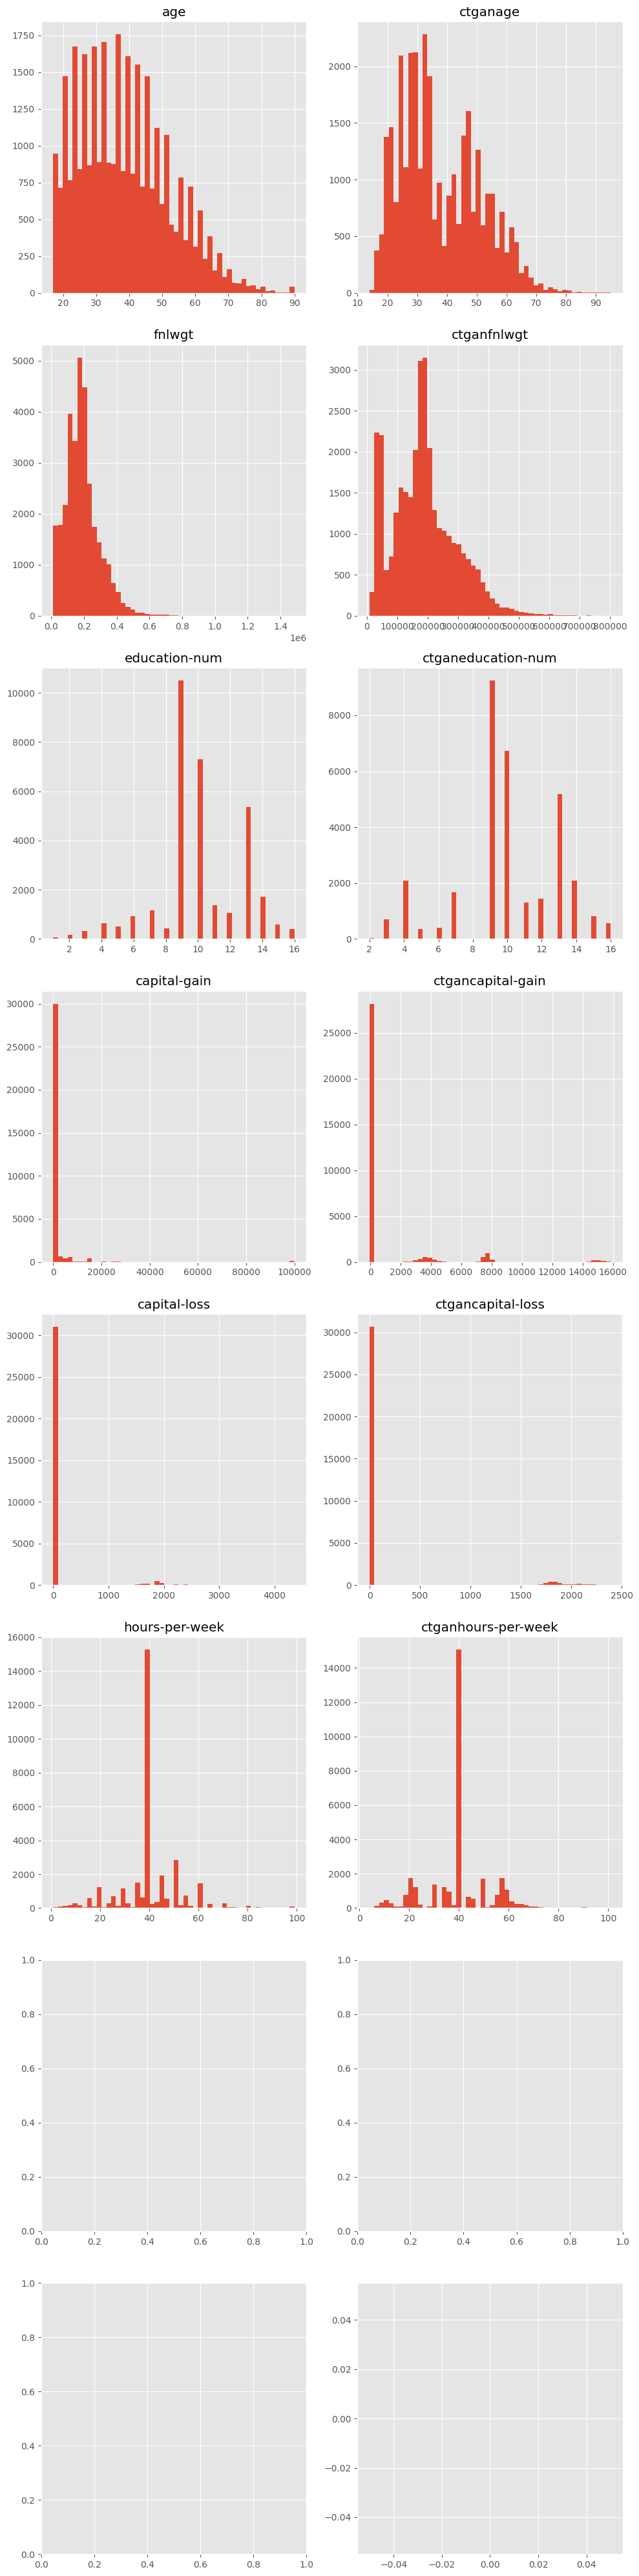

In [19]:
fig, ax = plt.subplots(figsize=(10,40), ncols=2, nrows=8)  

axes = ax.ravel()
for idx,col in zip(np.arange(0,22,2), continuous_list):      
    axes[idx].hist(data[col], bins =50)
    axes[idx].set_title(col)
    axes[idx+1].hist(vanilla_ctgna_df[col], bins =50)
    axes[idx+1].set_title('ctgan'+col)
plt.tight_layout() 
plt.plot()

In [19]:
vanilla_ctgna_df['revol.bal']

0        9950
1       10565
2       28091
3        2958
4       33989
        ...  
9573    13632
9574     5830
9575    25998
9576    22738
9577    16386
Name: revol.bal, Length: 9578, dtype: int64

In [21]:
data['revol.bal']

0        28854
1        33623
2         3511
3        33667
4         4740
         ...  
9573    215372
9574       184
9575     10036
9576         0
9577     37879
Name: revol.bal, Length: 9578, dtype: int64

In [65]:
data['NAME_INCOME_TYPE'].value_counts()

Working                 400164
Commercial associate    183385
Pensioner               128392
State servant            65437
Student                    337
Name: NAME_INCOME_TYPE, dtype: int64

In [66]:
vanilla_ctgna_df['NAME_INCOME_TYPE'].value_counts()

Working                 357517
Commercial associate    240458
Pensioner               117318
State servant            62422
Name: NAME_INCOME_TYPE, dtype: int64

[]

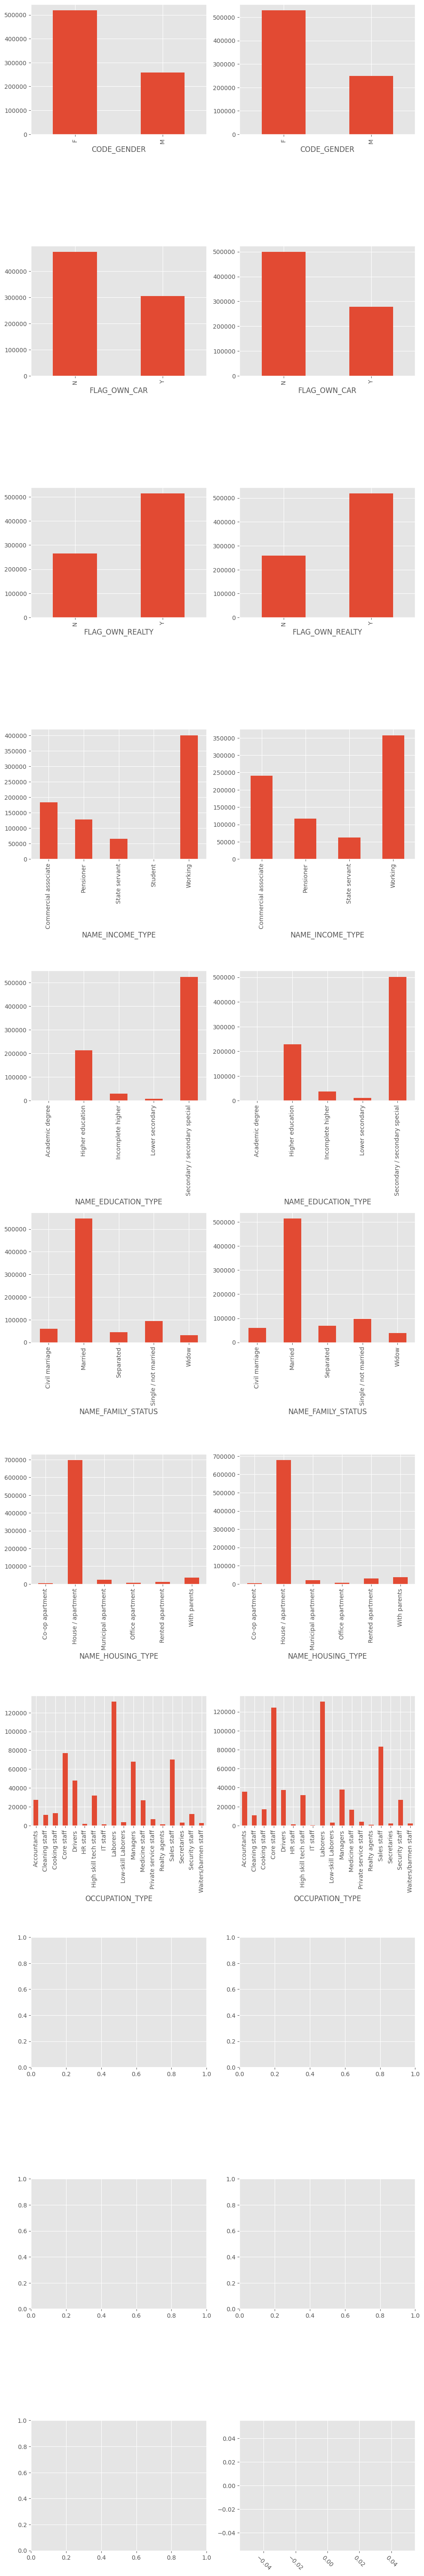

In [63]:
## 범주형 변수 그리기
fig, axes = plt.subplots(figsize=(10,60), ncols=2, nrows=11)  

# axes = ax.ravel()
for idx,col in zip(np.arange(0,11), categorical_list):      
    data[[col]].groupby([col])[col].count().plot.bar(ax=axes[idx][0])
    vanilla_ctgna_df[[col]].groupby([col])[col].count().plot.bar(ax=axes[idx][1])
plt.xticks(rotation=-45)
plt.tight_layout() 
plt.plot()

In [67]:
ctgan_cdf_df = pd.read_csv('ctgan_cdf_change_output.csv')
ctgan_cdf_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,M,N,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-20359,-2809,1,0,0,0,Laborers,2,-20,0
1,F,N,Y,0,157500.0,Working,Secondary / secondary special,Separated,House / apartment,-14883,-6195,1,0,1,0,Laborers,4,-5,1
2,M,N,Y,0,157500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-11958,-2423,1,0,0,0,Sales staff,2,-13,-1
3,M,N,N,0,90000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-12437,-8284,1,1,1,0,NaN,2,-33,0
4,M,Y,N,0,427500.0,State servant,Secondary / secondary special,Married,House / apartment,-12005,-4542,1,0,0,0,Drivers,2,-10,-1


In [74]:
data.shape

(777715, 19)

In [75]:
ctgan_cdf_df.shape

(777715, 19)

0
2
4
6
8
10
12
14
16
18
20


[]

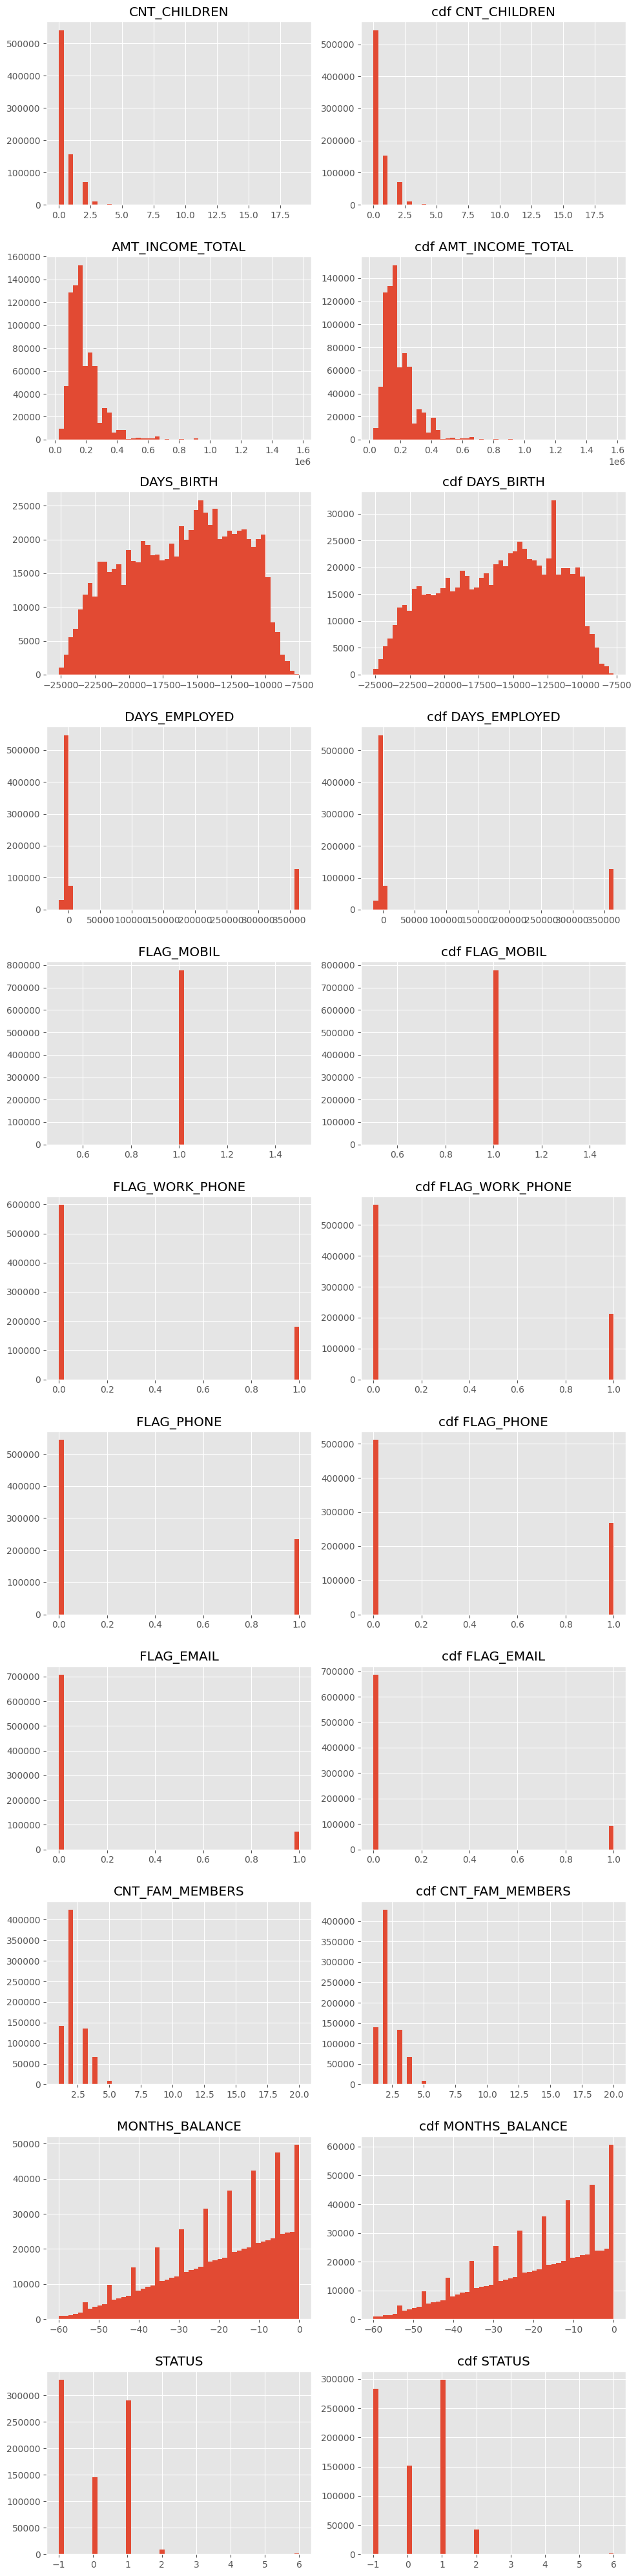

In [76]:
fig, ax = plt.subplots(figsize=(10,40), ncols=2, nrows=11)  

axes = ax.ravel()
for idx,col in zip(np.arange(0,22,2), continuous_list):      
    print(idx)
    axes[idx].hist(data[col], bins =50)
    axes[idx].set_title(col)
    axes[idx+1].hist(ctgan_cdf_df[col], bins =50)
    axes[idx+1].set_title('cdf '+col)
plt.tight_layout() 
plt.plot()